# 1. 서론

### 저는 주로 큰 데이터를 학습할 때 코랩을 씁니다. 로컬 하드웨어가 그렇게 좋지는 않아서...
### 하지만 이번 대회 데이터가 파일 수가 엄청 많아서 코랩에서 압축을 풀어도 압축이 다 풀리지 않고,
### 데이터를 풀어서 다 올리자니 시간이 엄청 오래걸려서 고민을 좀 했습니다.
### 그러다가 문득, train dataset을 학습하지 않고 test set만 가지고도 예측이 어느정도 가능하지 않을까? 라는 생각을 했습니다.
### 아래 zero-shot VQA는 이러한 생각에서 시작됐습니다.

# 2. 본론

### zero-shot VQA에 대한 논문을 찾아보면 여러가지가 있습니다.
### 특히 최근에는 LLM(Large Language Model)을 활용하여, 처리한 이미지와 질문 쌍을 Prompt에 넣어 답변을 출력받는 모델들이 많이 나오고 있습니다.
### 저는 이 모델들 중, 비교적 최근에 나온 Blip2를 활용하여 zero-shot predicting을 했습니다.
#### (참고 : https://arxiv.org/abs/2301.12597)
#### (이 블립 아닙니다...)

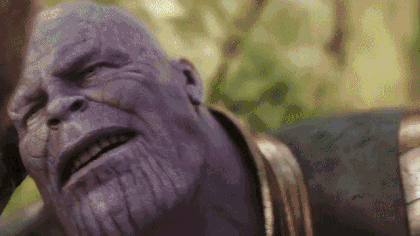

### Blip2는 Image encoder와 LLM을 놓고, 그 사이에 Q former라는 구조로 text를 처리하는 모델입니다.
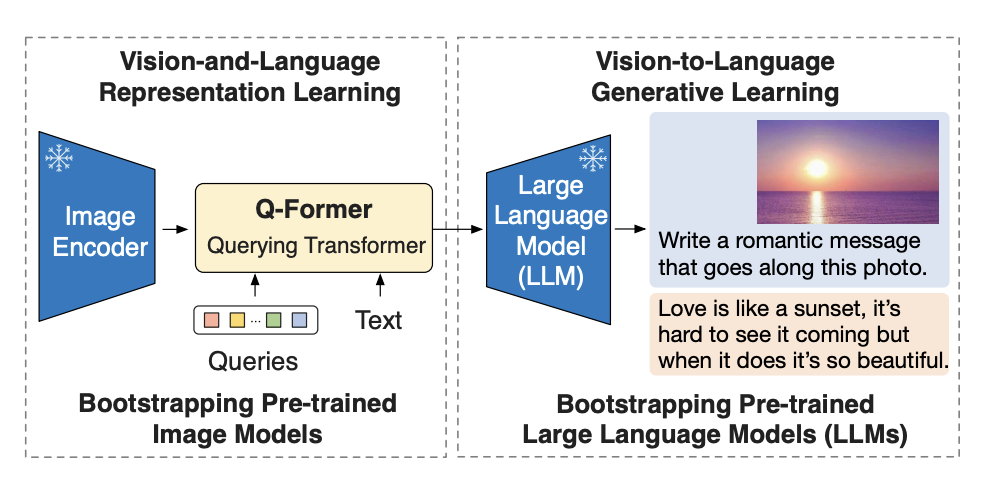

### 제가 blip2를 고른 이유는 다른건 아니고,
### 1. LLM을 활용하는 모델이다.
### 2. huggingface에 공개가 되어있으며, 사용하기 쉽다.
### 3. zero-shot VQA 정확도가 좋다.
### 이 3가지 이유입니다. 아래를 보시면, zero-shot VQA 정확도가 다른 모델에 비해 좋다는 것을 알 수 있습니다.
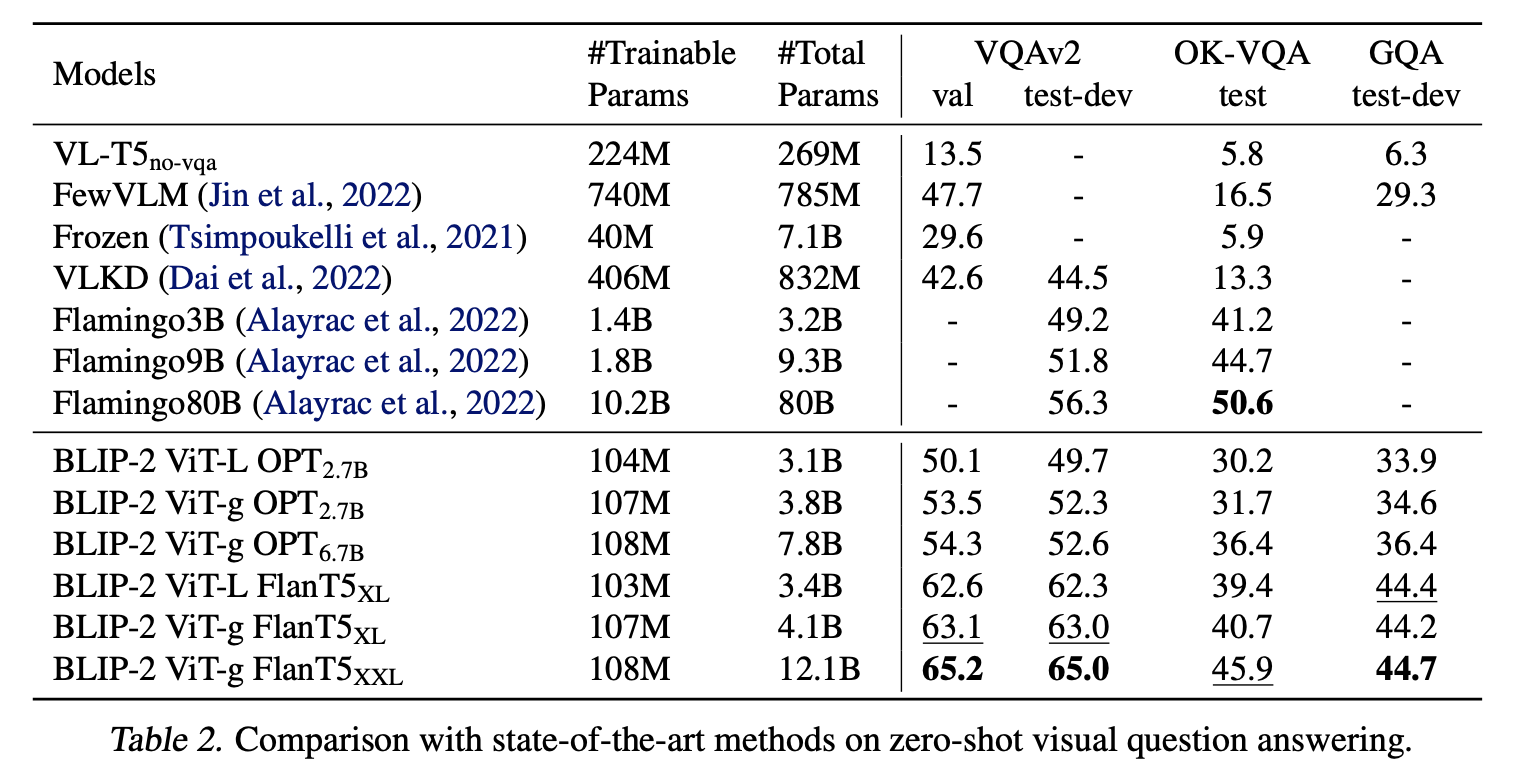

### 그럼 이제 blip2를 활용한 zero-shot VQA를 한번 살펴보겠습니다.
### 제가 사용했던 모델은 blip2 중에서도, FlanT5XL(pretrained-only) 모델입니다.
#### (참고 : https://huggingface.co/Salesforce/blip2-flan-t5-xl)
### huggingface를 보면 blip2 모델 중 pretrained-only모델이 있고, COCO 데이터셋에 fine-tuning된 모델이 있습니다.
### 이번 대회에서는 pretrained-only 모델만 사용가능했어서, 저는 위 주소에 있는 모델을 사용했습니다.
### XL 모델을 사용한 이유는,
### 1. XXL 모델에 비해서 용량은 훨씬 적은데 반해 정확도는 그렇게 낮지 않기 때문입니다.
### 실제로 XL 모델과 XXL 모델을 비교해보면, XL모델은 용량이 15GB정도인데 반해 XXL모델은 무려 50GB ;; 정도입니다.
### train 가급적 안하려고 위 모델 불러왔는데 배보다 배꼽이 클 수 없었기에... XL모델을 활용했습니다.
### 2. OPT 모델에 비해서는 zero-shot 정확도가 많이 높았기 때문입니다. 그래서 선택했습니다.
#### * OPT와 Flan-T5는 모두 LLM 모델의 이름입니다.



### 저는 코랩에서 진행했습니다. 로컬이나 kaggle등 환경에서 진행하실분은 로컬이나 kaggle에서 진행해주세요.
### 우선, 아래 코드를 통해 transformer를 최신 버전으로 설치하고, accelerate를 설치합니다.

In [ ]:
!pip install -U transformers
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 110.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 3.6 MB/s eta 0:00:00


### 사실 아래 라이브러리 다 필요없습니다. Pandas, transformers, tqdm 정도만 있으면 됩니다.
### 다만 저는 웬만한 라이브러리는 불러오는 성격이라, 아래 코드는 수정 없이 진행했습니다.

In [ ]:
import numpy as np
import pandas as pd
import operator
import os
import string
import re
import random
import sys
import platform

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from PIL import Image

from transformers import Blip2Processor, Blip2ForConditionalGeneration

from tqdm.auto import tqdm

### test csv파일과 image path, 그리고 sample_submission csv파일을 불러옵니다.
### test 이미지는 파일이 그렇게 크지않아서 그냥 구글 드라이브에 저장해놨습니다.

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Dacon_multimodal_for_zeroshot/test.csv')
test_img_path = '/content/drive/MyDrive/Dacon_multimodal_for_zeroshot/image/'
sample_submission = pd.read_csv('/content/drive/MyDrive/Dacon_multimodal_for_zeroshot/sample_submission.csv')

### 그리고 아래 코드를 실행해주시면 됩니다.
### 저는 full precision으로 진행했으며, A100 GPU로 예측했습니다. 시간은 한 4시간~5시간 정도 걸렸습니다.
### A100 GPU가 부담스럽거나 하시면 V100이나 T4혹은 kaggle에서 제공하는 P100 GPU로 진행하시면 됩니다.
### 다만 이런 경우는 input 부분에 .to(cuda)를 .to("cuda", torch.float16)으로 해서 half precision으로 바꿔서 하는걸 추천드립니다.
### 정확도는 조금 떨어져도 더 빨리, 그리고 용량 부담 적게 예측할 수 있습니다.
### 중간에 혹시 멈출수도 있어서, 100개 이미지 및 질문 예측 할때마다 저장하는거로 했습니다.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = Blip2Processor.from_pretrained("Salesforce/blip2-flan-t5-xl")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-flan-t5-xl")
model.to(device)

final_submission = sample_submission.copy()

for idx, row in tqdm(test_df.iterrows()):
    img_name = os.path.join(test_img_path, row['image_id'] + '.jpg')  # 이미지
    image = Image.open(img_name).convert('RGB')

    prompt =  "Question : {} answer:".format(row['question'])
    inputs = processor(images=image, text=prompt, return_tensors="pt").to(device)

    generated_ids = model.generate(**inputs)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

    generated_text = convert_word_to_number(generated_text)

    final_submission.loc[final_submission['ID'] == row['ID'], 'answer'] = generated_text

    if idx%100 == 0:
        final_submission.to_csv('/content/drive/MyDrive/Dacon_multimodal_for_zeroshot/submission_zeroshot_blip2.csv', index=False)

final_submission.to_csv('/content/drive/MyDrive/Dacon_multimodal_for_zeroshot/submission_zeroshot_blip2_no_adjust.csv', index=False)

### 위 코드로 예측 후 제출한 결과는 아래와 같습니다.
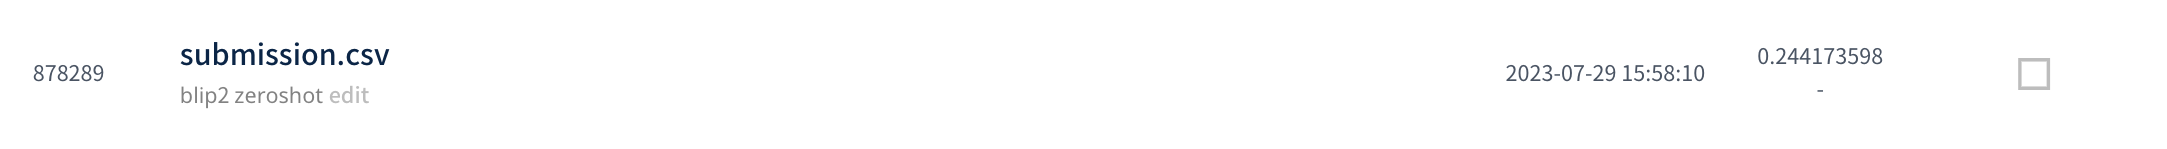

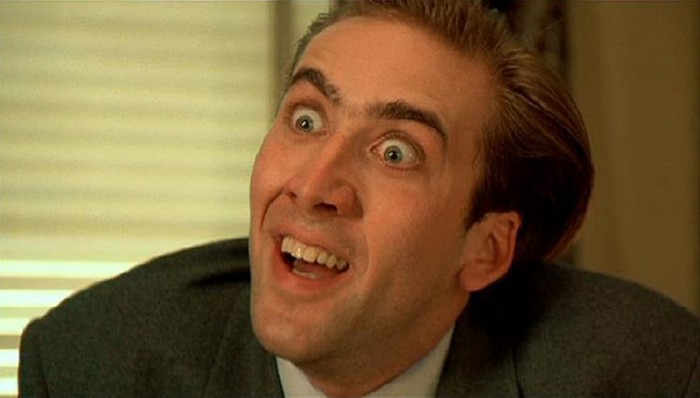

## ????? 아니 뭐야 Baseline보다도 낮잖아?

### 이유가 있습니다. 문제가 되는 부분은 해당 부분입니다.
### prompt =  "Question : {} answer:".format(row['question'])
### 이 모델은 LLM의 Prompt를 활용하는 모델입니다. ChatGPT를 사용하시면 알겠지만, 같은 질문을 어떤 형식으로 물어보느냐에 따라 GPT가 대답하는 형식도 달라집니다.
### 즉, Prompt Engineering이 필요한 부분입니다. 위에처럼 그냥 단순히 question을 주고 answer를 뱉도록 하면,
### 예를 들어 Does this person look to be relaxing? 이라는 질문을 넣으면,
### train 데이터처럼 단순히 Yes라고 하는게 아니라 Yes, because he is lying on the couch. 이런식으로 대답을 합니다.

### 저처럼 일찍이 이런 고민을 하신 분들이 있던 것 같습니다.
### Investigating Prompting Techniques for Zero- and Few-Shot Visual Question Answering이라는 논문에서,
### Prompt 에 질문을 주는 방식을 바꿔감에 따라 정확도가 어떻게 바뀌는지를 연구한 결과가 있었습니다. 마침 사용 모델도 Blip2라, 저도 논문을 따라해보기로 했습니다.
#### (참고 : https://arxiv.org/abs/2306.09996)


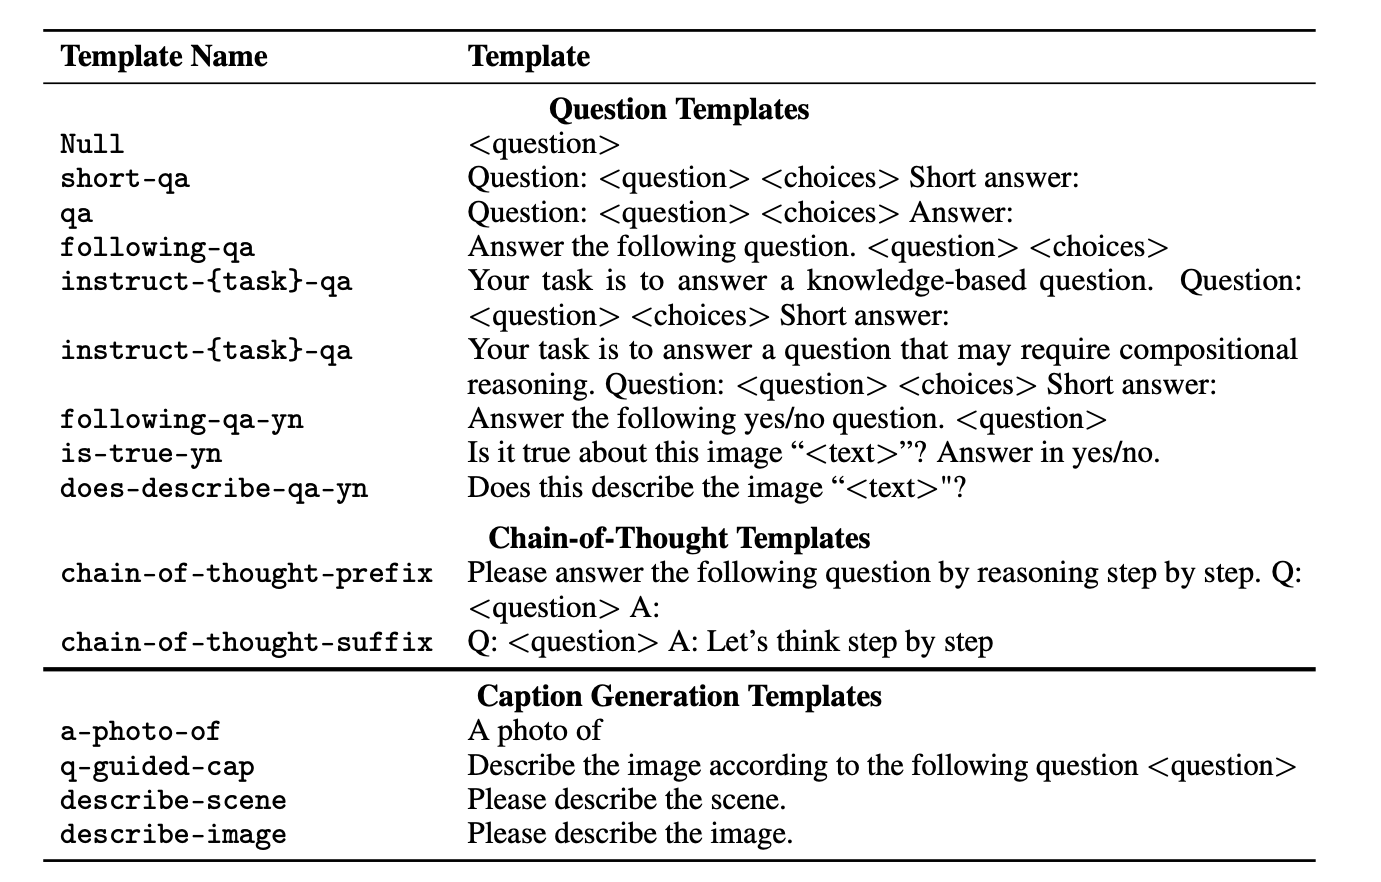

### Prompt에 질문을 주는 방식을 위처럼 구분하여 작성한 것을 볼 수 있습니다.
### 제가 맨 처음에 했던 것 처럼 qa 방식으로 단순히 question, answer를 넣는 것 부터 시작해서,
### 짧은 답변을 원한다면 question-short answer 방식으로, yes-no를 원한다면 끝에 Answer in yes/no.를 붙이는 등 다양하게 Prompt를 다룹니다.

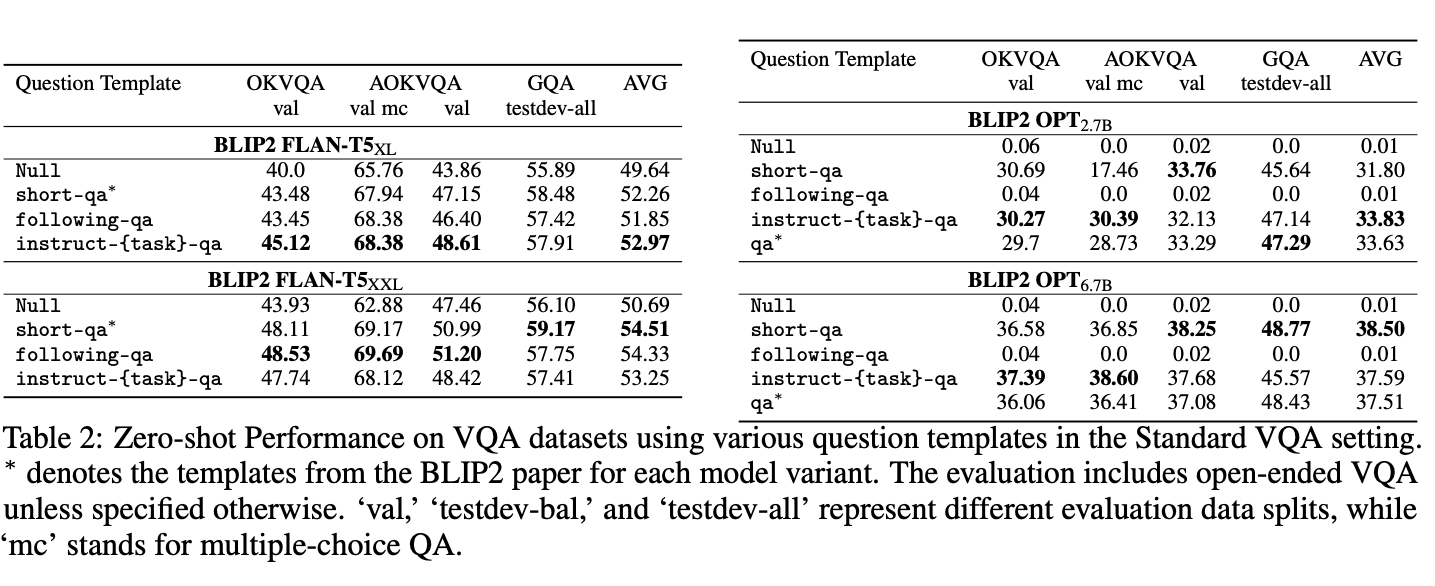

### 그리고 모델별로, Prompt에 Question을 어떻게 주느냐에 따라 정확도가 어떻게 달라졌는지의 결과를 보여줍니다.
### Prompt에 질문하는 방식을 바꾼 것 만으로도 정확도가 상당히 달라진 것을 볼 수 있습니다.
### 저는 지금 Flan-T5XL모델을 쓰고 있으므로, 위 결과에 따라 instruct-{task}-qa방식으로 해보겠습니다.
### 다만 train 모델에 맞춰, 답을 좀 더 짧게 하기 위해 short answer를 추가하였습니다. Instruct도 논문보단 조금 길게 줬습니다.

#### * 추가로 Bilp2-FlanT5XL 모델이 내는 답을 살펴보니, 숫자를 영어 단어로 내뱉는 것을 확인했습니다.
#### 즉 1이면 one 이렇게 answer를 내뱉고 있었습니다.
#### train 데이터와는 조금 맞지 않으므로, 아래 코드를 추가하여 영단어를 다시 아라비아 숫자로 바꾸겠습니다.

In [ ]:
number_words_dict = {
    "zero": 0,
    "one": 1,
    "two": 2,
    "three": 3,
    "four": 4,
    "five": 5,
    "six": 6,
    "seven": 7,
    "eight": 8,
    "nine": 9,
}

def convert_word_to_number(text):
    words = text.lower().split()
    for word in words:
        if word in number_words_dict:
            return str(number_words_dict[word])
    return text

### 아래 코드로 다시 zero-shot을 실행해보겠습니다.
### prompt에 instruct를 추가하여 좀 더 길어졌으며, 끝에 short answer가 붙은게 보이실 겁니다.
### 또한 yes/no를 좀 더 확실히 뱉기 위해, generated된 답에 yes나 no가 포함되면 그냥 yes/no로 답변이 나오게 했으며, 숫자의 경우 아라비아 숫자로 바꿔 출력되게 했습니다.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = Blip2Processor.from_pretrained("Salesforce/blip2-flan-t5-xl")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-flan-t5-xl")
model.to(device)

final_submission = sample_submission.copy()

for idx, row in tqdm(test_df.iterrows()):
    img_name = os.path.join(test_img_path, row['image_id'] + '.jpg')  # 이미지
    image = Image.open(img_name).convert('RGB')

    prompt = "Your task is to answer a question that is knowledge-based or may require compositional reasoning. If the answer is represented as a numerical word, just output it as an Arabic numeral. Question : {} Short answer:".format(row['question'])
    inputs = processor(images=image, text=prompt, return_tensors="pt").to(device)

    generated_ids = model.generate(**inputs)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

    if "yes" in generated_text:
        generated_text = "yes"
    elif "no" in generated_text:
        generated_text = "no"

    generated_text = convert_word_to_number(generated_text)

    final_submission.loc[final_submission['ID'] == row['ID'], 'answer'] = generated_text

    if idx%100 == 0:
        final_submission.to_csv('/content/drive/MyDrive/Dacon_multimodal_for_zeroshot/submission_zeroshot_blip2.csv', index=False)

final_submission.to_csv('/content/drive/MyDrive/Dacon_multimodal_for_zeroshot/submission_zeroshot_blip2.csv', index=False)

In [ ]:
final_submission

ID            answer
0      TEST_00000                no
1      TEST_00001      on the beach
2      TEST_00002               red
3      TEST_00003             white
4      TEST_00004                no
...           ...               ...
40474  TEST_40474  a digital camera
40475  TEST_40475          graffiti
40476  TEST_40476               air
40477  TEST_40477               red
40478  TEST_40478              near

[40479 rows x 2 columns]

### 위 코드로 실행한 결과값은 아래와 같습니다.

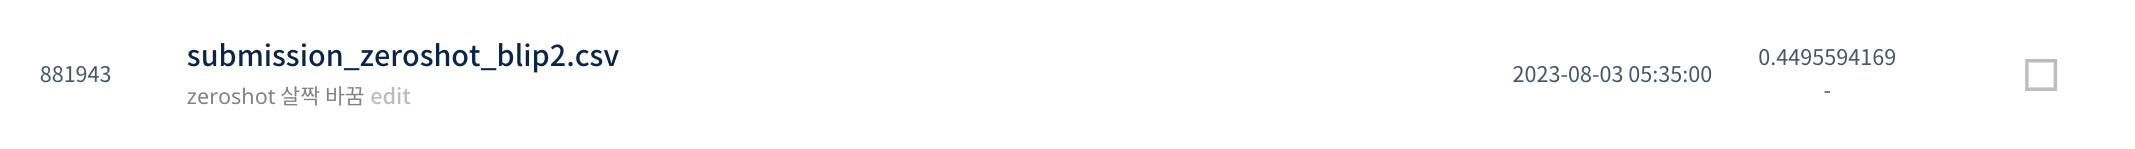

### Prompt를 바꿔주고, 나오는 답을 살짝 후처리한 것만으로도 정확도가 크게 오른 것을 확인할 수 있습니다.

### 이렇게 LLM을 이용한 VQA 모델은 별도의 fine-tuning없이 Prompt를 이용해서 원하는 답을 쉽게 이끌어낼 수 있어 활용하기 편하다는 이점을 지닙니다.
### 또한, 컴퓨팅 자원이 한정되어 있을 때도 활용하기 쉽습니다.
### 다만 대회의 경우에는 정해진 답이 있으므로, 정확히 정해진 답에 맞추기에는 무리가 조금 있긴 합니다.

### 추가적으로, generate함수에서 sampling 및 확률을 조작하여 좀 더 다채로운 답변을 모델이 내놓도록 할 수도 있습니다.
#### (참고 : Transformer로 텍스트를 생성하는 다섯가지 전략 / https://littlefoxdiary.tistory.com/46)
### Greedy search, Beem search, top k sampling 등 다양한 전략이 있는데, 위에 Prompt 전략과 더불어서 쓴다면 모델이 정말 유창한 답변을 하는 것을 볼 수 있을겁니다.
#### (여기서는 train 점수 올리는데 더 신경을 써서 해당 전략은 사용하지 않았습니다.)

# 3. 마무리

### ChatGPT 등장 이후 지속적으로 LLM 모델이 나오고 있습니다.
### 여러 부분에서 LLM 모델을 활용 중인데, VQA에서도 LLM을 활용하여 이미지와 질문을 통해 다양한 답변을 생성한다는 아이디어가 정말 좋은 것 같습니다.
### 실제로 현업에서도 이렇게 LLM을 활용한 VQA 모델을 fine-tuning하여 의료 VQA 모델 등을 만들고 있는데(Med-Flamingo 등),
### 이처럼 앞으로 더 활발히 Multimodal 분야가 연구되어 다채로운 분야에서 AI모델을 만나기를 기대합니다.
### 더위가 절정으로 지나고, 태풍도 온다고 하는데 다들 건강유의하시고 즐거운 코딩/머신러닝/딥러닝 하시기 바랍니다. 감사합니다.